# 3.1. Serving an encrypted model
**protecting privacy and IP simultaneously**


### Use case: Skin cancer detection

Many people regularly check their skin for changes. Not all moles, patches, and rashes are cancerous. In this tutorial we'll train a model to differenciate between benign keratosis and melanoma (type of skin cancer).

Seborrheic keratosis is a noncancerous condition that can look a lot like melanoma. About 83 million Americans have seborrheic keratosis. About 5 percent of all new cancer cases in the United States are melanoma, a potentially deadly form of skin cancer. With prompt treatment, more than 91 percent of melanoma patients will survive 5 years or more after their first diagnosis. (Source: https://www.medicalnewstoday.com/articles/320742.php)


## Train a model

The first thing we need is a model, we can train a model using **regular pytorch**! If you're familiar with pytorch feel free to skip this part of the tutorial.

Most of the code used in this part of the tutorial is actually at `skin_cancer_model_utils.py` have a look at it if you want to know in more details what's going on in each subsection of this notebook.

### Dataset

We'll use this [kaggle dataset](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/). You need to download this dataset before running this example and eventually change the permissions of the files contained in the downloaded archive so that they can be parsed in Python:

chmod 666 'file_name'

We use the code available at [this kaggle kernel](https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing) by Kevin Mader and in [this tutorial](https://towardsdatascience.com/skin-cancer-classification-with-machine-learning-c9d3445b2163) by Nyla Pirani to preprocess the data.

In the previous tutorial we served a CNN for classifying images with different 2 types of skin deseases: benign keratosis and melanoma (type of skin cancer). In this tutorial we show how to serve this model on a **encrypted way** on Grid.

### Dependencies for training the model

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.transforms as transforms

import skin_cancer_model_utils as scmu

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Path where the data is stored. Change this if needed!
scmu.DATASET_PATH

'./skin-cancer-mnist-ham10000'

**Read dataset**

In [2]:
df = scmu.read_skin_cancer_dataset()
df['cell_type'].value_counts()

Melanoma                         1113
Benign keratosis-like lesions    1099
Name: cell_type, dtype: int64

**Visualize dataset**

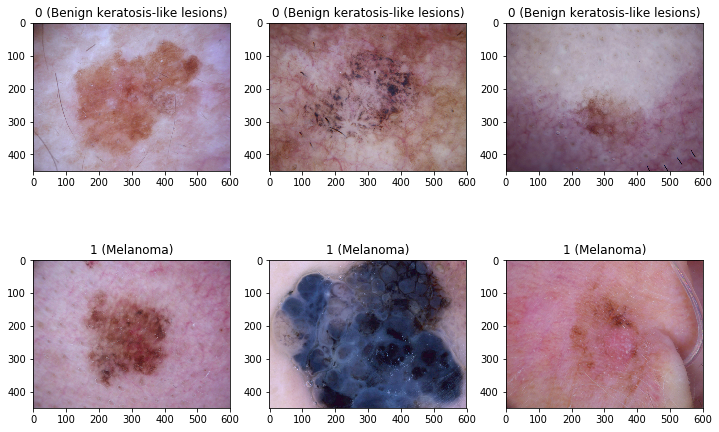

In [3]:
# Get samples from each class
samples = df.groupby('cell_type').apply(lambda x: x.sample(3))

# Plot samples
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 2
for i in range(len(samples)):
    image = mpimg.imread(samples["path"].iloc[i])
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(image)
    title = "{} ({})".format(samples["cell_type_idx"].iloc[i], samples["cell_type"].iloc[i])
    plt.title(title)
plt.show()

**Prepare data for training**

In [4]:
train_df, valid_df, test_df = scmu.split_data(df)

In [5]:
# Parameters for the dataloader
input_size = 32
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 6}

# Calculate train_mean and train_std
training_set = scmu.Dataset(train_df, transform=transforms.Compose([
                               transforms.Resize((input_size, input_size)),
                               transforms.ToTensor()]))
training_generator = torch.utils.data.DataLoader(training_set, **params)
train_mean, train_std = scmu.calculate_mean_and_std(training_generator)

In [6]:
train_mean, train_std

(tensor([0.6979, 0.5445, 0.5735]), tensor([0.0959, 0.1187, 0.1365]))

In [7]:
# Create dataloaders
training_set = scmu.Dataset(train_df, transform=scmu.transform(input_size, train_mean, train_std))
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = scmu.Dataset(valid_df, transform=scmu.transform(input_size, train_mean, train_std))
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

test_set = scmu.Dataset(test_df, transform=scmu.transform(input_size, train_mean, train_std))
test_generator = torch.utils.data.DataLoader(test_set, **params)

**Implement model**

In [8]:
model = scmu.make_model()
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

**Train model**

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [10]:
train_metrics, valid_metrics = scmu.train(model, epochs=10, optimizer=optimizer,
                                          training_generator=training_generator,
                                          validation_generator=validation_generator)

Training loss at step 0 = 0.6908872723579407
Training loss at step 100 = 0.7087734937667847
Epoch: 0
Train
Average loss: 0.6845, Accuracy: 1053/1990 (52.9%)

Test
Average loss: 0.6860, Accuracy: 576/1106 (52.1%)

Training loss at step 200 = 0.6831835508346558
Epoch: 1
Train
Average loss: 0.6764, Accuracy: 1150/1990 (57.8%)

Test
Average loss: 0.6781, Accuracy: 634/1106 (57.3%)

Training loss at step 300 = 0.6463944315910339
Epoch: 2
Train
Average loss: 0.6662, Accuracy: 1243/1990 (62.5%)

Test
Average loss: 0.6690, Accuracy: 680/1106 (61.5%)

Training loss at step 400 = 0.6783669590950012
Epoch: 3
Train
Average loss: 0.6570, Accuracy: 1206/1990 (60.6%)

Test
Average loss: 0.6613, Accuracy: 666/1106 (60.2%)

Training loss at step 500 = 0.6564556360244751
Training loss at step 600 = 0.6659862995147705
Epoch: 4
Train
Average loss: 0.6492, Accuracy: 1280/1990 (64.3%)

Test
Average loss: 0.6523, Accuracy: 721/1106 (65.2%)

Training loss at step 700 = 0.6478021740913391
Epoch: 5
Train
Averag

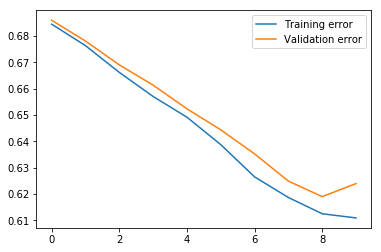

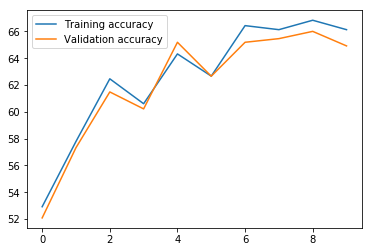

In [26]:
plt.plot([train_metric[0] for train_metric in train_metrics], label ='Training error')
plt.plot([valid_metric[0] for valid_metric in valid_metrics], label ='Validation error')
plt.legend()
plt.show()
plt.plot([train_metric[1] for train_metric in train_metrics], label ='Training accuracy')
plt.plot([valid_metric[1] for valid_metric in valid_metrics], label ='Validation accuracy')
plt.legend()
plt.show()

**Evaluate model**

In [27]:
scmu.test(model, test_generator)

Average loss: 0.6059, Accuracy: 738/1106 (66.7%)



(0.6059427541591376, 66.72694394213381)

In [28]:
torch.save(model.state_dict(), "skin-cancer-model")

## Serve model


Before running the cells below make sure to run the websocket grid clients locally:

```bash
cd ../../app/websocket/
python websocket_app.py --start_local_db --id=grid_server --port=3001

python websocket_app.py --start_local_db --id=patient_server --port=3000

python websocket_app.py --start_local_db --id=hospital_server --port=3002

python websocket_app.py --start_local_db --id=crypto_provider --port=3003
```

In [1]:
# Import dependencies
import grid as gr
from grid import syft as sy
import torch as th
import skin_cancer_model_utils as scmu

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Hook torch
hook = sy.TorchHook(th)
me = hook.local_worker
me.is_client_worker = False
    
# Connect to nodes
grid_server = gr.WebsocketGridClient(hook, "http://localhost:3001", id="grid_server")
patient_server = gr.WebsocketGridClient(hook, "http://localhost:3000", id="patient_server")
hospital_server = gr.WebsocketGridClient(hook, "http://localhost:3002", id="hospital_server")
crypto_provider = gr.WebsocketGridClient(hook, "http://localhost:3003", id="crypto_provider")

grid_server.connect()
patient_server.connect()
hospital_server.connect()
crypto_provider.connect()

# Connect nodes to each other
gr.connect_all_nodes([grid_server, patient_server, hospital_server, crypto_provider])

In [2]:
data, target = scmu.get_data_sample()

### Making a model ready to be served and encrypted

In order to serve the model it needs to be serializable. A Plan is intended to store a sequence of torch operations, just like a function, but it allows to send this sequence of operations to remote workers and to keep a reference to it. You can learn more about plans in [Syft's tutorials](https://github.com/OpenMined/PySyft/blob/dev/examples/tutorials/Part%2008%20-%20Introduction%20to%20Plans.ipynb).


### Define Model

Let's load the model we just trained.

In [3]:
model = scmu.make_model(is_plan=True, model_id="skin-cancer-model-encrypted")
model.load_state_dict(th.load("skin-cancer-model"))

In [4]:
model

<Net Net id:skin-cancer-model-encrypted owner:me>

In [5]:
model.build(data)

## Serve model

In [6]:
model.encrypt(patient_server, hospital_server, crypto_provider=crypto_provider)

<Net Net id:skin-cancer-model-encrypted owner:me built>

In [7]:
grid_server.serve_encrypted_model(model)

True